In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Для работы с матрицами
from scipy.sparse import csr_matrix

# Матричная факторизация
from implicit import als

# Модель второго уровня
from lightgbm import LGBMClassifier

import os, sys
module_path = os.path.abspath(os.path.join(os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

# Написанные нами функции
from webinar6.metrics import precision_at_k, recall_at_k
from webinar6.utils import prefilter_items
from webinar6.recommenders import MainRecommender

## Read data

In [3]:
data = pd.read_csv('./retail_train.csv')
item_features = pd.read_csv('./product.csv')
user_features = pd.read_csv('./hh_demographic.csv')

# Process features dataset

In [4]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'

In [5]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]
user_features.columns = [col.lower() for col in user_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True)
user_features.rename(columns={'household_key': USER_COL }, inplace=True)

# Split dataset for train, eval, test

In [6]:
# Важна схема обучения и валидации!
# -- давние покупки -- | -- 6 недель -- | -- 3 недель -- 
# подобрать размер 2-ого датасета (6 недель) --> learning curve (зависимость метрики recall@k от размера датасета)


VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

In [7]:
# берем данные для тренировки matching модели
data_train_matcher = data[data['week_no'] < data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data['week_no'] >= data['week_no'].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data['week_no'] < data['week_no'].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  # Для наглядности. Далее мы добавим изменения, и они будут отличаться

# берем данные для теста ranking, matching модели
data_val_ranker = data[data['week_no'] >= data['week_no'].max() - VAL_RANKER_WEEKS]

In [8]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [10]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')
# видим разброс по пользователям и товарам

train_matcher
Shape: (2108779, 12) Users: 2498 Items: 83685
val_matcher
Shape: (169711, 12) Users: 2154 Items: 27649
train_ranker
Shape: (169711, 12) Users: 2154 Items: 27649
val_ranker
Shape: (118314, 12) Users: 2042 Items: 24329


In [11]:
data_train_matcher.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


# Prefilter items

In [12]:
n_items_before = data_train_matcher['item_id'].nunique()

data_train_matcher = prefilter_items(data_train_matcher, item_features=item_features, take_n_popular=5000)

n_items_after = data_train_matcher['item_id'].nunique()
print('Decreased # items from {} to {}'.format(n_items_before, n_items_after))

/home/alex/resommendation-systems/webinar6/utils.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = data['sales_value'] / (np.maximum(data['quantity'], 1))
Decreased # items from 83685 to 5001


# Make cold-start to warm-start

In [13]:
# ищем общих пользователей
common_users = list(set(data_train_matcher.user_id.values)&(set(data_val_matcher.user_id.values))&set(data_val_ranker.user_id.values))

data_train_matcher = data_train_matcher[data_train_matcher.user_id.isin(common_users)]
data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users)]
data_train_ranker = data_train_ranker[data_train_ranker.user_id.isin(common_users)]
data_val_ranker = data_val_ranker[data_val_ranker.user_id.isin(common_users)]

print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (784420, 13) Users: 1915 Items: 4999
val_matcher
Shape: (163261, 12) Users: 1915 Items: 27118
train_ranker
Shape: (163261, 12) Users: 1915 Items: 27118
val_ranker
Shape: (115989, 12) Users: 1915 Items: 24042


In [14]:
# Теперь warm-start по пользователям

# Init/train recommender

In [15]:
recommender = MainRecommender(data_train_matcher)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/4999 [00:00<?, ?it/s]

In [16]:
# Берем тестового юзера 2375

In [17]:
recommender.get_als_recommendations(2375, N=5)

[899624, 1044078, 1106523, 871756, 5569230]

In [18]:
recommender.get_own_recommendations(2375, N=5)

[948640, 918046, 847962, 907099, 873980]

In [19]:
recommender.get_similar_items_recommendation(2375, N=5)

[1046545, 1044078, 823990, 10355376, 15778319]

In [20]:
recommender.get_similar_users_recommendation(2375, N=5)

[825317, 977559, 835351, 935578, 8090542]

**Задание 1.**

A) Попробуйте различные варианты генерации кандидатов. Какие из них дают наибольший recall@k ?
- Пока пробуем отобрать 50 кандидатов (k=50)
- Качество измеряем на data_val_matcher: следующие 6 недель после трейна

Дают ли own recommendtions + top-popular лучший recall?  

B)* Как зависит recall@k от k? Постройте для одной схемы генерации кандидатов эту зависимость для k = {20, 50, 100, 200, 500}  
C)* Исходя из прошлого вопроса, как вы думаете, какое значение k является наиболее разумным?

In [22]:
result_match = data_val_matcher.groupby('user_id')['item_id'].unique().reset_index()
result_match.columns=['user_id', 'actual']
result_match.head()

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
2,7,"[836281, 843306, 845294, 914190, 920456, 93886..."
3,8,"[868075, 886787, 945611, 1005186, 1008787, 101..."
4,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1..."


In [24]:
data_val_matcher.groupby('user_id')['item_id'].unique().reset_index().head()

,user_id,item_id
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,6,"[1024306, 1102949, 6548453, 835394, 940804, 96..."
2,7,"[836281, 843306, 845294, 914190, 920456, 93886..."
3,8,"[868075, 886787, 945611, 1005186, 1008787, 101..."
4,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1..."


In [25]:
K = 50

In [27]:
new_users = np.setdiff1d(result_match['user_id'], data_train_matcher['user_id']).tolist()
result_match = result_match[~result_match['user_id'].isin(new_users)]

In [28]:
# Own recommendations
result_match['own_recommendations'] = result_match['user_id'].apply(lambda X: recommender.get_own_recommendations(X, N=K))
result_match.apply(lambda vector: recall_at_k(vector['own_recommendations'], vector['actual'], K), axis=1).mean()

0.06168420135329065

In [29]:
# als
result_match['own_recommendations'] = result_match['user_id'].apply(lambda X: recommender.get_als_recommendations(X, N=K))
result_match.apply(lambda vector: recall_at_k(vector['own_recommendations'], vector['actual'], K), axis=1).mean()

0.04780930630155854

In [30]:
# similar items
result_match['own_recommendations'] = result_match['user_id'].apply(lambda X: recommender.get_similar_items_recommendation(X, N=K))
result_match.apply(lambda vector: recall_at_k(vector['own_recommendations'], vector['actual'], K), axis=1).mean()

0.030898440528564705

### Наилучший результат дает Own recommendations (top popular)

In [33]:
n = [20, 50, 100, 200, 500]
rec_list = []

for i in n:
    result_match['own_recommendations'] = result_match['user_id'].apply(lambda X: recommender.get_own_recommendations(X, N=i))
    rec_list.append(result_match.apply(lambda vector: recall_at_k(vector['own_recommendations'], vector['actual'], i), axis=1).mean())

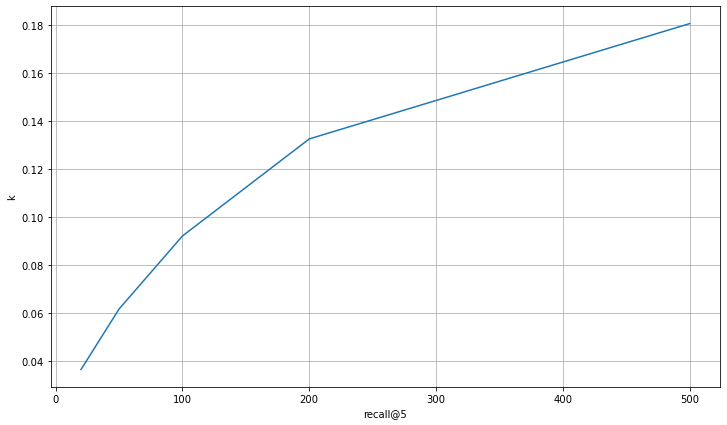

In [34]:
plt.figure(figsize=(12, 7))
plt.plot(n, rec_list)
plt.xlabel("recall@5")
plt.ylabel("k")
plt.grid(True)

### recall@k растет при увеличении k

Думаю, что наиболлее разумно выбрать k$\approx$100. Хотя нужно учитывать уоличество рекомендуемых товаров

**Задание 2.**

Обучите модель 2-ого уровня, при этом:

- Добавьте минимум по 2 фичи для юзера, товара и пары юзер-товар

- Измерьте отдельно precision@5 модели 1-ого уровня и двухуровневой модели на data_val_ranker

- Вырос ли precision@5 при использовании двухуровневой модели?

### Добавляем признаки продуктам

In [43]:
new_item_features = item_features.merge(data, on='item_id', how='left')
new_item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,quantity_of_sales_x,weekly_quantity_of_sales_x,price_x,...,basket_id,day,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,3,0.031579,3.49,...,29046618323,157,1,3.49,3313,0.0,2213,23,0.0,0.0
1,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,3,0.031579,3.49,...,30707611686,247,1,3.49,3266,0.0,1211,36,0.0,0.0
2,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,3,0.031579,3.49,...,33046710871,410,4,13.96,3191,0.0,1139,59,0.0,0.0
3,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,1,0.010526,0.99,...,30760265177,250,1,0.99,3235,0.0,936,36,0.0,0.0
4,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,1,0.010526,1.59,...,33783848749,458,1,1.59,33904,0.0,2034,66,0.0,0.0


In [44]:
# Количество продаж в неделю
item_quantity = new_item_features.groupby(['item_id'])['quantity'].count().reset_index()
item_quantity.rename(columns={'quantity': 'quantity_of_sales'}, inplace=True)
item_quantity['quantity_of_sales_weekly'] = item_quantity['quantity_of_sales'] / new_item_features['week_no'].nunique()
item_quantity.head()

,item_id,quantity_of_sales,quantity_of_sales_weekly
0,25671,3,0.031579
1,26081,1,0.010526
2,26093,1,0.010526
3,26190,1,0.010526
4,26355,1,0.010526


In [45]:
# Средняя цена
price = new_item_features.groupby('item_id')['sales_value'].sum() / new_item_features.groupby('item_id')['quantity'].sum()
price = price.groupby('item_id').mean().reset_index()
price.columns = ['item_id', 'avg_price']
price['avg_price'].fillna(0, inplace= True)
price.head()

,item_id,avg_price
0,25671,3.49
1,26081,0.99
2,26093,1.59
3,26190,1.54
4,26355,0.99


In [46]:
# Добавим среднюю цену и количество продуктов к признакам продуктов
item_features = item_features.merge(item_quantity, on='item_id')
item_features = item_features.merge(price, on='item_id')
item_features = item_features[item_features['quantity_of_sales_weekly'] > 0]
item_features.head()

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,quantity_of_sales_x,weekly_quantity_of_sales_x,price_x,quantity_of_sales_y,weekly_quantity_of_sales_y,price_y,quantity_of_sales,quantity_of_sales_weekly,avg_price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,3,0.031579,3.49,3,0.031579,3.49,3,0.031579,3.49
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,1,0.010526,0.99,1,0.010526,0.99,1,0.010526,0.99
2,26093,69,PASTRY,Private,BREAD,BREAD:ITALIAN/FRENCH,,1,0.010526,1.59,1,0.010526,1.59,1,0.010526,1.59
3,26190,69,GROCERY,Private,FRUIT - SHELF STABLE,APPLE SAUCE,50 OZ,1,0.010526,1.54,1,0.010526,1.54,1,0.010526,1.54
4,26355,69,GROCERY,Private,COOKIES/CONES,SPECIALTY COOKIES,14 OZ,1,0.010526,0.99,1,0.010526,0.99,1,0.010526,0.99


### Добавляем признаки пользователей

In [47]:
new_user_features = user_features.merge(data, on='user_id', how='left')
new_user_features.head()

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,27601281299,51,825123,1,3.99,436,0.00,1456,8,0.0,0.0
1,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,27601281299,51,831447,1,2.99,436,0.00,1456,8,0.0,0.0
2,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,27601281299,51,840361,1,1.09,436,-0.30,1456,8,0.0,0.0
3,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,27601281299,51,845307,1,3.71,436,-0.62,1456,8,0.0,0.0
4,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1,27601281299,51,852014,1,2.79,436,-1.20,1456,8,0.0,0.0


In [50]:
new_user_features['income_desc'] = new_user_features['income_desc'].fillna('0')
new_user_features['income_desc'] = new_user_features['income_desc'].apply(lambda in_desc: in_desc.split(sep="-")[0])
new_user_features['income_desc'].head()

0    35
1    35
2    35
3    35
4    35
Name: income_desc, dtype: object

In [52]:
# Добавим среднюю корзину
basket = new_user_features.groupby(['user_id'])['sales_value'].sum().reset_index()
basket_quantity = new_user_features.groupby('user_id')['basket_id'].count().reset_index()
basket_quantity.rename(columns={'basket_id': 'basket_quantity'}, inplace=True)
avg_basket = basket.merge(basket_quantity)
avg_basket['avg_basket'] = avg_basket.sales_value / avg_basket.basket_quantity
avg_basket['weekly_sum'] = avg_basket.sales_value / new_user_features.week_no.nunique()
avg_basket = avg_basket.drop(['sales_value', 'basket_quantity'], axis=1)

user_features = user_features.merge(avg_basket)

In [54]:
def preprocessing(data, data_match):
    users_rank = pd.DataFrame(data['user_id'].unique())
    users_rank.columns = ['user_id']
    train_users = data_match['user_id'].unique()
    users_rank = users_rank[users_rank['user_id'].isin(train_users)]
    users_rank_ = users_rank.copy()
    users_rank['candidates'] = users_rank['user_id'].apply(lambda x: recommender.get_own_recommendations(x, N=50))
    s = users_rank.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
    s.name = 'item_id'
    users_rank = users_rank.drop('candidates', axis=1).join(s)
    users_rank['flag'] = 1
    targets_rank = data[['user_id', 'item_id']].copy()
    targets_rank.head(2)
    targets_rank['target'] = 1  
    targets_rank = users_rank.merge(targets_rank, on=['user_id', 'item_id'], how='left')
    targets_rank['target'].fillna(0, inplace= True)
    targets_rank.drop('flag', axis=1, inplace=True)
    targets_rank = targets_rank.merge(item_features, on='item_id', how='left')
    targets_rank = targets_rank.merge(user_features, on='user_id', how='left')
    X = targets_rank.drop('target', axis=1)
    y = targets_rank[['target']]
    
    return X, y

In [55]:
X_train, y_train = preprocessing(data_train_ranker, data_train_matcher)
X_test, y_test = preprocessing(data_val_ranker, data_val_matcher)

In [56]:
cat_feats = X_train.columns[2:].tolist()
cat_feats

['manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'quantity_of_sales_x',
 'weekly_quantity_of_sales_x',
 'price_x',
 'quantity_of_sales_y',
 'weekly_quantity_of_sales_y',
 'price_y',
 'quantity_of_sales',
 'quantity_of_sales_weekly',
 'avg_price',
 'age_desc',
 'marital_status_code',
 'income_desc',
 'homeowner_desc',
 'hh_comp_desc',
 'household_size_desc',
 'kid_category_desc',
 'avg_basket',
 'weekly_sum']

In [57]:
X_train[cat_feats] = X_train[cat_feats].astype('category')
X_test[cat_feats] = X_test[cat_feats].astype('category')

In [59]:
lgb = LGBMClassifier(objective='binary', max_depth=10, categorical_column=cat_feats)
lgb.fit(X_train, y_train)

test_preds_proba = lgb.predict_proba(X_test)[:, 1]

/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
/home/alex/miniconda3/envs/py36/lib/python3.6/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


In [62]:
def get_recomendation(X_test, test_preds_proba, data_val_ranker):
    X_test['predict_proba'] = test_preds_proba
    X_test.sort_values(['user_id', 'predict_proba'], ascending=False, inplace=True)
    result = X_test.groupby('user_id').head(5)
    recs = result.groupby('user_id')['item_id']
    recomendations = []
    for user, preds in recs:
        recomendations.append({'user_id': user, 'recomendations': preds.tolist()})
    recomendations = pd.DataFrame(recomendations)
    result_rank = data_val_ranker.groupby('user_id')['item_id'].unique().reset_index()
    result_rank.columns=['user_id', 'actual']
    result_rank = result_rank.merge(recomendations)
    
    return result_rank

In [63]:
result_rank = get_recomendation(X_test, test_preds_proba, data_val_ranker)

In [64]:
result_rank.apply(lambda row: precision_at_k(row['recomendations'], row['actual']), axis=1).mean()

0.07049608355091384

precision@5 при использовании двухуровневой модели вырос